# Tutorial

This tutorial shows how to perform diffusion-weighted MR simulations using Disimpy. To follow along, [install](https://disimpy.readthedocs.io/en/latest/installation.html) the package and execute the code in each cell in the order that they are presented.e the funce the func

You can also use Google Colaboratory to run this notebook [interactively in your browser](https://colab.research.google.com/github/kerkelae/disimpy/blob/master/docs/source/tutorial.ipynb) even if you don't have an Nvidia CUDA-capable GPU. To use a GPU on Google Colaboratory, select *Runtime > Change runtime type > Hardware Type: GPU* in the top menu.

In [1]:
# If Disimpy has not been installed, uncomment the following line and
# execute the code in this cell

#!pip install git+https://github.com/kerkelae/disimpy.git

In [2]:
# Import the packages and modules used in this tutorial

import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

from disimpy import gradients, simulations, substrates, utils

import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)

## Simulation parameters

We need to define the number of random walkers and diffusivity. In this tutorial, we will use a small number of random walkers to keep the simulation runtime short and to be able to quickly visualize the simulated random walks. However, in actual experiments, a larger number of random walkers should be used to make sure that signal converges, and the random walk trajectories do not need not be saved.

In [3]:
n_walkers = int(1e3)
diffusivity = 2e-9

## Gradient arrays

We need to define a gradient array that contains the necessary information about the simulated magnetic field gradients for diffusion encoding. Gradient arrays are `numpy.ndarray` instances with shape (number of measurements, number of time points, 3). The elements of gradient arrays are floating-point numbers representing the gradient magnitude along an axis at a time point in SI units (T/m). The module `disimpy.gradients` contains several useful functions for creating and modifying gradient arrays. In the example below, we define a gradient array to be used in this tutorial.

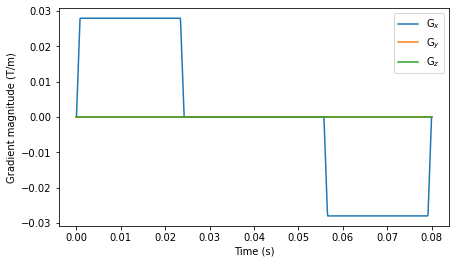

In [4]:
# Create a simple Stejskal-Tanner gradient waveform

gradient = np.zeros((1, 100, 3))
gradient[0, 1:30, 0] = 1
gradient[0, 70:99, 0] = -1


# Concatenate 100 gradient arrays with different b-values together

bs = np.linspace(1, 3e9, 100)  # Array of b-values in SI units (s/m^2)
gradient = np.concatenate([gradient for _ in bs], axis=0)


# Adjust the gradient magnitude and number of time points

n_t = int(1e3)  # Number of time points in the simulation
T = 80e-3  # Duration of gradient array in seconds
dt = T / (gradient.shape[1] - 1)  # Duration of time step in seconds
gradient, dt = gradients.interpolate_gradient(gradient, dt, n_t)
gradient = gradients.set_b(gradient, dt, bs)


# Show the gradient magnitude over time of the 50th measurement

fig, ax = plt.subplots(1, figsize=(7, 4))
for i in range(3):
    ax.plot(np.linspace(0, T, n_t), gradient[50, :, i])
ax.legend(['G$_x$', 'G$_y$', 'G$_z$'])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Gradient magnitude (T/m)')
plt.show()

## Substrates

We need to define the simulated diffusion environment, referred to as a substrate, using substrate objects. The module `disimpy.substrates` contains functions for creating substrate objects. Disimpy supports simulating diffusion without restrictions, inside a sphere, inside an infinite cylinder, inside an ellipsoid, and restricted by arbitrary geometries defined by triangular meshes.

### Free diffusion

Starting simulation
The trajectories file will be up to 0.075 GB
Number of random walkers = 1000
Number of steps = 1000
Step length = 9.84731927834662e-07 m
Step duration = 8.080808080808081e-05 s
Simulation finished


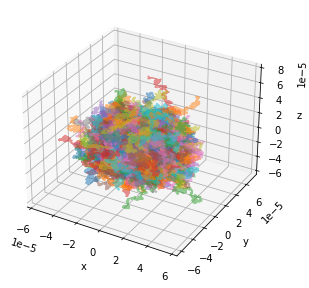

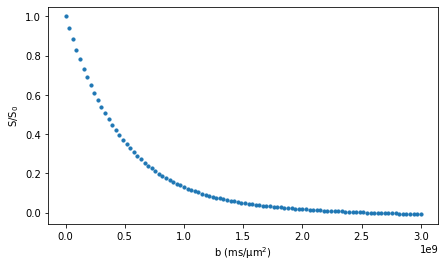

In [5]:
# Create a substrate object for free diffusion

substrate = substrates.free()


# Run simulation and show the random walker trajectories

traj_file = 'example_traj.txt'
signals = simulations.simulation(
    n_walkers, diffusivity, gradient, dt, substrate, traj=traj_file)
utils.show_traj(traj_file)


# Plot the simulated signal

fig, ax = plt.subplots(1, figsize=(7, 4))
ax.scatter(bs, signals / n_walkers, s=10)
ax.set_xlabel('b (ms/μm$^2$)')
ax.set_ylabel('S/S$_0$')
plt.show()

### Spheres

Simulating diffusion inside a sphere requires specifying the radius of the sphere:

Starting simulation
The trajectories file will be up to 0.075 GB
Number of random walkers = 1000
Number of steps = 1000
Step length = 9.84731927834662e-07 m
Step duration = 8.080808080808081e-05 s
Simulation finished


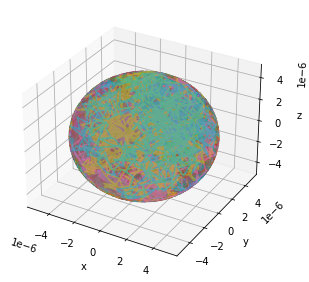

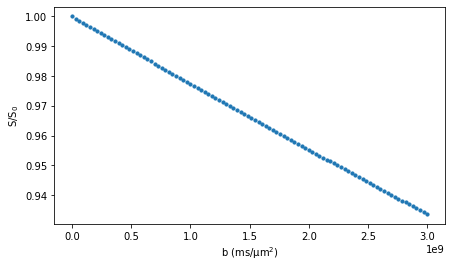

In [6]:
# Create a substrate object for diffusion inside a sphere

substrate = substrates.sphere(radius=5e-6)


# Run simulation and show the random walker trajectories

traj_file = 'example_traj.txt'
signals = simulations.simulation(
    n_walkers, diffusivity, gradient, dt, substrate, traj=traj_file)
utils.show_traj(traj_file)


# Plot the simulated signal

fig, ax = plt.subplots(1, figsize=(7, 4))
ax.scatter(bs, signals / n_walkers, s=10)
ax.set_xlabel('b (ms/μm$^2$)')
ax.set_ylabel('S/S$_0$')
plt.show()

### Infinite cylinder

Simulating diffusion inside an infinite cylinders requires specifying the radius and orientation of the cylinder:

Starting simulation
The trajectories file will be up to 0.075 GB
Number of random walkers = 1000
Number of steps = 1000
Step length = 9.84731927834662e-07 m
Step duration = 8.080808080808081e-05 s
Simulation finished


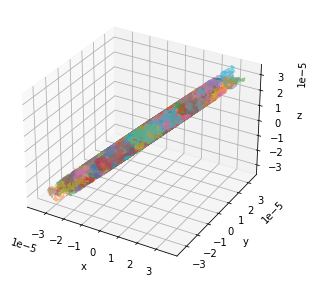

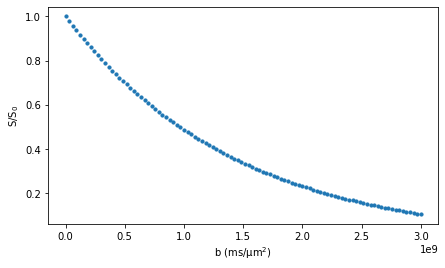

In [7]:
# Create a substrate object for diffusion inside an infinite cylinder

substrate = substrates.cylinder(
    radius=5e-6, orientation=np.array([1., 1., 1.]))


# Run simulation and show the random walker trajectories

traj_file = 'example_traj.txt'
signals = simulations.simulation(
    n_walkers, diffusivity, gradient, dt, substrate, traj=traj_file)
utils.show_traj(traj_file)


# Plot the simulated signal

fig, ax = plt.subplots(1, figsize=(7, 4))
ax.scatter(bs, signals / n_walkers, s=10)
ax.set_xlabel('b (ms/μm$^2$)')
ax.set_ylabel('S/S$_0$')
plt.show()

### Ellipsoids

Simulating diffusion inside an ellipsoid requires specifying the ellipsoid semiaxes and a rotation matrix, defining the ellipsoid orientation, according to which the axis-aligned ellipsoid is rotated before the simulation:

Starting simulation
The trajectories file will be up to 0.075 GB
Number of random walkers = 1000
Number of steps = 1000
Step length = 9.84731927834662e-07 m
Step duration = 8.080808080808081e-05 s
Simulation finished


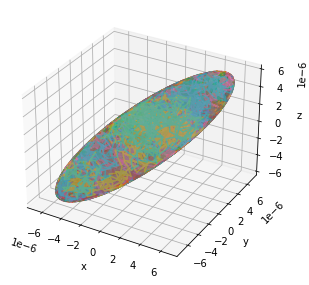

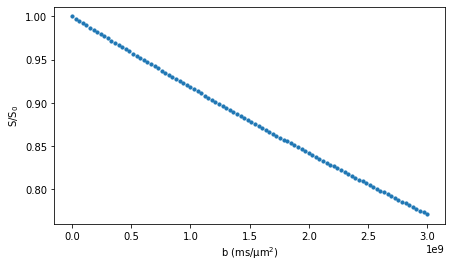

In [8]:
# Create a substrate object for diffusion inside an ellipsoid

v = np.array([1., 0, 0])
k = np.array([1., 1., 1.])
R = utils.vec2vec_rotmat(v, k)  # R for aligning v with k
substrate = substrates.ellipsoid(
    semiaxes=np.array([10e-6, 5e-6, 2.5e-6]), R=R)


# Run simulation and show the random walker trajectories

traj_file = 'example_traj.txt'
signals = simulations.simulation(
    n_walkers, diffusivity, gradient, dt, substrate, traj=traj_file)
utils.show_traj(traj_file)


# Plot the simulated signal

fig, ax = plt.subplots(1, figsize=(7, 4))
ax.scatter(bs, signals / n_walkers, s=10)
ax.set_xlabel('b (ms/μm$^2$)')
ax.set_ylabel('S/S$_0$')
plt.show()

### Triangular meshes

Diffusion inside arbitrary geometries can be simulated using triangular meshes. To convert meshes in various file formats into the required arrays, you can use [meshio](https://pypi.org/project/meshio/), for example.

To be used with Disimpy, triangular meshes must be represented by a pair of `numpy.ndarray` instances: vertices array of shape (number of points, 3) containing the points of the triangular mesh, and faces array of shape (number of triangles, 3) defining how the triangles are made up of the vertices. The simulated voxel is equal to the axis-aligned bounding box of the triangles plus optional padding. Before the simulation, the triangles are moved so that the bottom corner of the simulated voxel is at the origin.

By default, the initial positions of the random walkers are randomly sampled from a uniform distribution over the simulated voxel. If the triangles define a closed surface, the initial positions of the random walkers can be randomly sampled from a uniform distribution over the volume inside or outside the surface. The initial positions can also be defined manually.

Disimpy supports periodic and reflective boundary conditions. If periodic boundary conditions are used, the random walkers encounter infinitely repeating identical copies of the simulated microstructure after they leave the simulated voxel. Otherwise, the boundaries of the simulated voxel are treated as impermeable surfaces.

The code below loads an example mesh and shows how to generate a substrate object for simulating diffusion inside the closed surface.

Aligning the corner of the simulated voxel with the origin
Moved the vertices by [0. 0. 0.]
Dividing mesh into subvoxels
Finished dividng mesh into subvoxels


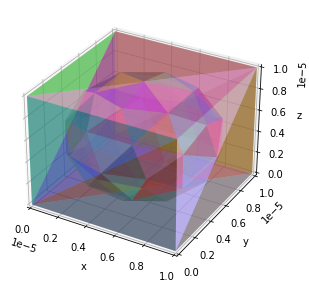

Starting simulation
The trajectories file will be up to 0.75 GB
Number of random walkers = 10000
Number of steps = 1000
Step length = 9.84731927834662e-07 m
Step duration = 8.080808080808081e-05 s
Calculating initial positions
Finished calculating initial positions
Simulation finished


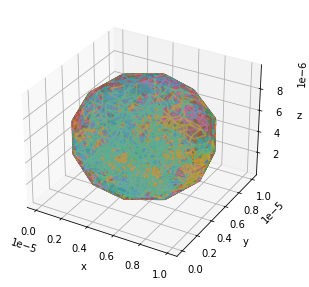

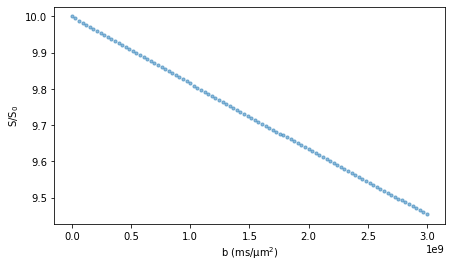

In [9]:
# Load an example triangular mesh

mesh_path = os.path.join(
    os.path.dirname(simulations.__file__), 'tests', 'sphere_mesh.pkl')
with open(mesh_path, 'rb') as f:
    example_mesh = pickle.load(f)
faces = example_mesh['faces']
vertices = example_mesh['vertices']


# Create a substrate object

substrate = substrates.mesh(
    vertices, faces, padding=np.zeros(3), periodic=False, init_pos='intra')


# Show the mesh

utils.show_mesh(substrate)


# Run simulation and show the random walker trajectories

traj_file = 'example_traj.txt'
signals = simulations.simulation(
    int(1e4), diffusivity, gradient, dt, substrate, traj=traj_file)
utils.show_traj(traj_file)


# Plot the simulated signal

fig, ax = plt.subplots(1, figsize=(7, 4))
ax.scatter(bs, signals / n_walkers, s=10, alpha=.5)
ax.set_xlabel('b (ms/μm$^2$)')
ax.set_ylabel('S/S$_0$')
plt.show()

Aligning the corner of the simulated voxel with the origin
Moved the vertices by [0. 0. 0.]
Dividing mesh into subvoxels
Finished dividng mesh into subvoxels


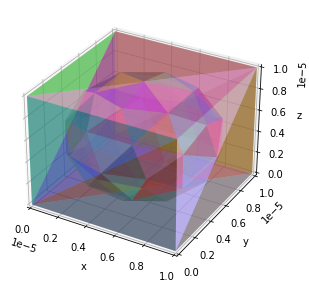

In [10]:
# Create and show a substrate object without periodic boundary conditions

substrate = substrates.mesh(
    vertices, faces, padding=np.zeros(3), periodic=False, init_pos='intra')
utils.show_mesh(substrate)

In [11]:
# Detailed information about the functions can be found in the docstrings

simulations.simulation?

Signature:
simulations.simulation(
    n_walkers,
    diffusivity,
    gradient,
    dt,
    substrate,
    seed=123,
    traj=None,
    final_pos=False,
    all_signals=False,
    quiet=False,
    cuda_bs=128,
    max_iter=1000,
    epsilon=1e-13,
)
Docstring:
Simulate a diffusion-weighted MR experiment and generate signal. For a
detailed tutorial, please see
https://disimpy.readthedocs.io/en/latest/tutorial.html.

Parameters
----------
n_walkers : int
    Number of random walkers.
diffusivity : float
    Diffusivity in SI units (m^2/s).
gradient : numpy.ndarray
    Floating-point array of shape (number of measurements, number of time
    points, 3). Array elements represent the gradient magnitude at a time
    point along an axis in SI units (T/m).
dt : float
    Duration of a time step in the gradient array in SI units (s).
substrate : disimpy.substrates._Substrate
    Substrate object containing information about the simulated
    microstructure.
seed : int, optional
    Seed for p

## Advanced information

For details, please see the [function documentation](https://disimpy.readthedocs.io/en/latest/modules_and_functions.html) and  [source code](https://github.com/kerkelae/disimpy).